In [1]:
#Importing library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Importing all the preprocessed dataset 

In [2]:
train_no_val2 = pd.read_csv("../dataset/processed1/train_no_val2.csv", index_col=0)
train_no_val1 = train_no_val2.loc[(train_no_val2['Date']<'2017-11-01')]
train_complete = pd.read_csv("../dataset/processed1/train.csv", index_col=0)

val1 = train_no_val2.loc[((train_no_val2['Date']>='2017-11-01') & (train_no_val2['Date']<='2017-12-31'))]
val2 = pd.read_csv("../dataset/processed1/val2.csv", index_col=0)

test = pd.read_csv("../dataset/processed1/test.csv", index_col=0)

Modifying the date

In [3]:
train_no_val1.OrdinalDate = train_no_val1.OrdinalDate.map(lambda x: x % 365)
train_no_val2.OrdinalDate = train_no_val2.OrdinalDate.map(lambda x: x % 365)
train_complete.OrdinalDate = train_complete.OrdinalDate.map(lambda x: x % 365)

val1.OrdinalDate = val1.OrdinalDate.map(lambda x: x % 365)
val2.OrdinalDate = val2.OrdinalDate.map(lambda x: x % 365)

test.OrdinalDate = test.OrdinalDate.map(lambda x: x % 365)

D:\Programmi\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Preparing train-val-test set

In [4]:
y_train_no_val1 = train_no_val1['NumberOfSales']
y_train_no_val2 = train_no_val2['NumberOfSales']
y_train_complete = train_complete['NumberOfSales']

y_val1 = val1['NumberOfSales']
y_val2 = val2['NumberOfSales']

X_train_no_val1 = train_no_val1.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)
X_train_no_val2 = train_no_val2.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)
X_train_complete = train_complete.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)

X_val1 = val1.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)
X_val2 = val2.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)

X_test = test.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)

Selecting the best features

Feature ranking:
1. feature 41 MeanStoreSales (0.487321)
2. feature 0 HasPromotions (0.142672)
3. feature 42 StdStoreSales (0.135869)
4. feature 37 WasOpenYesterday (0.035757)
5. feature 36 OrdinalDate (0.013200)
6. feature 20 NearestCompetitor (0.012962)
7. feature 40 StdMonthSales (0.012864)
8. feature 39 MeanMonthSales (0.012466)
9. feature 34 IsSaturday (0.011147)
10. feature 25 StoreType (0.008548)
11. feature 38 IsOpenTomorrow (0.008433)
12. feature 43 MeanRegionSales (0.008242)
13. feature 44 StdRegionSales (0.006831)
14. feature 22 Region_AreaKM2 (0.006252)
15. feature 26 WindDirDegrees (0.006219)
16. feature 5 Max_Sea_Level_PressurehPa (0.005830)
17. feature 17 Min_Sea_Level_PressurehPa (0.005208)
18. feature 23 Region_GDP (0.005060)
19. feature 11 Mean_Sea_Level_PressurehPa (0.005045)
20. feature 3 Max_Gust_SpeedKm_h (0.004870)
21. feature 16 Min_Humidity (0.004811)
22. feature 10 Mean_Humidity (0.004767)
23. feature 6 Max_TemperatureC (0.004750)
24. feature 35 IsSunday (0.00

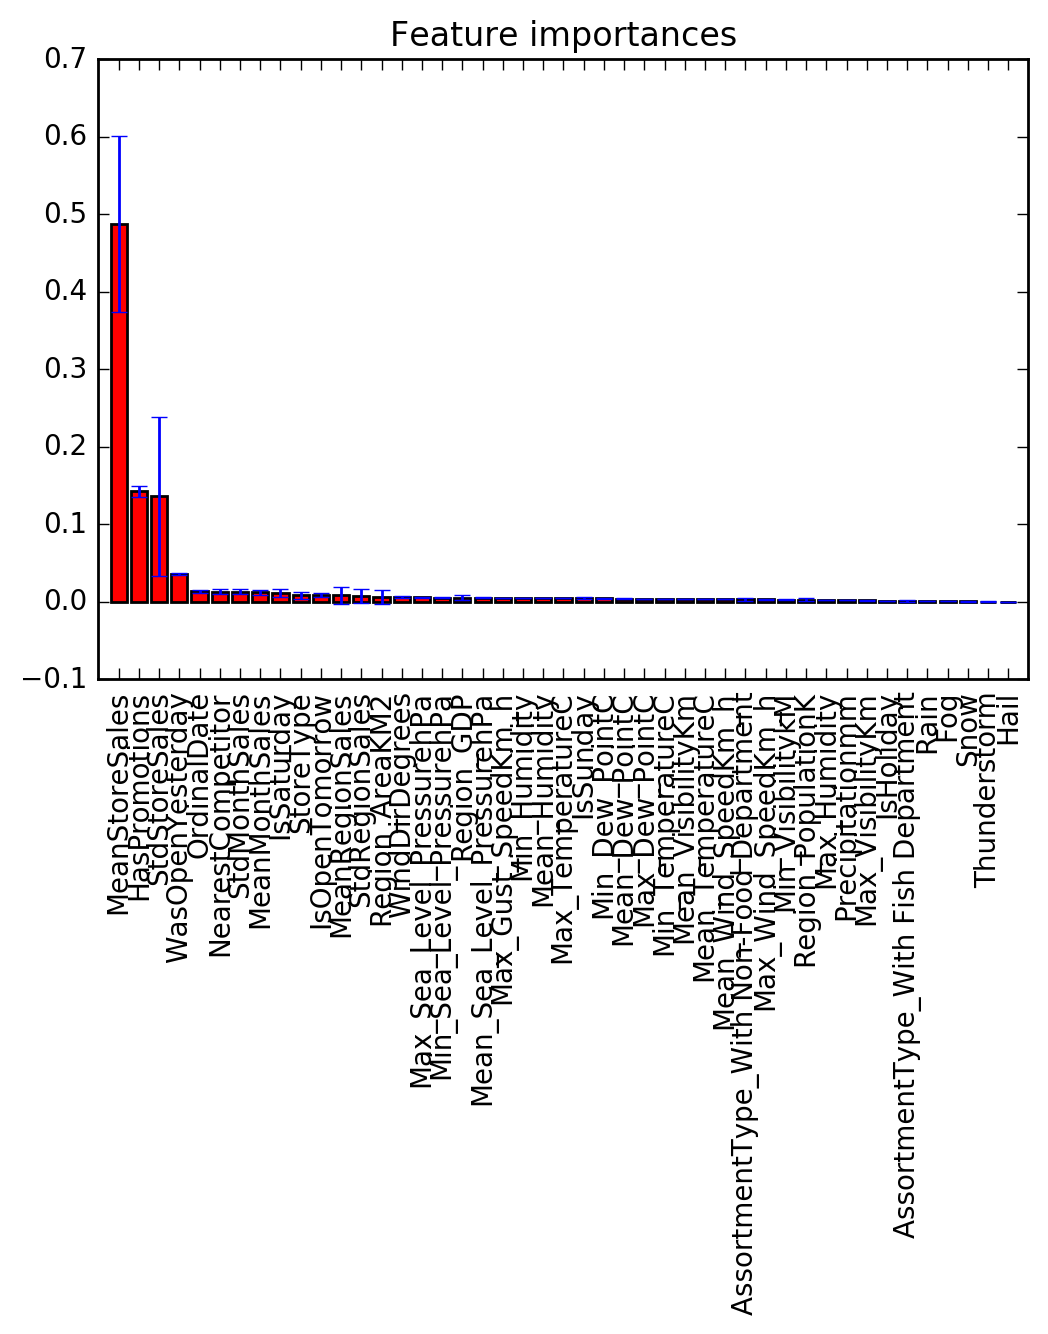

In [5]:
forest = RandomForestRegressor(max_depth=40, random_state=0, n_estimators=100, max_features=21, n_jobs=-1)
forest.fit(X_train_no_val1, y_train_no_val1)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_no_val1.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X_train_no_val1.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_no_val1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_no_val1.shape[1]), X_train_no_val1.columns[indices] ,rotation=90)
plt.xlim([-1, X_train_no_val1.shape[1]])
plt.show()

In [6]:
feature_selection_model = SelectFromModel(forest, threshold=0.0065, prefit=True)

X_train_no_val1 = feature_selection_model.transform(X_train_no_val1)
X_train_no_val2 = feature_selection_model.transform(X_train_no_val2)
X_train_complete = feature_selection_model.transform(X_train_complete)

X_val1 = feature_selection_model.transform(X_val1)
X_val2 = feature_selection_model.transform(X_val2)

X_test = feature_selection_model.transform(X_test)

compute the model for val2

Function used to compute the error

In [7]:
def calcola_errore(ypred, y, val):
    val=val.reset_index(drop=True)
    y = y.reset_index(drop=True)

    columns=['Date', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']
    index=range(y.shape[0])
    result=pd.DataFrame(index=index,columns=columns)

    result['Date']=val['Date']
    result['StoreID']=val['StoreID']
    result['RegionID']=val['Region']
    result['SalesPredicted']=ypred
    result['SalesReal']=y
    

    # Transform dates from '%Y-%m-%d' to datetime objects.
    def transform_date(x):
        date = datetime.datetime.strptime(x, '%Y-%m-%d')
        return date

    result['Date'] = result['Date'].map(transform_date)
    result['Month'] = result.Date.map(lambda d: d.strftime('%Y-%m'))
    result = result.groupby(['StoreID', 'RegionID', 'Month']).sum().reset_index()[['Month', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']]

    result['SalesError'] = abs(result.SalesPredicted - result.SalesReal)

    region_error = (result.groupby('RegionID').sum().SalesError / result.groupby('RegionID').sum().SalesReal).reset_index().rename(columns={0: 'RegionError'}).set_index('RegionID')
    total_error = np.mean(region_error.RegionError)
    return total_error

In [9]:
#best parameters
na=4
depth=15
nt=250

In [11]:
forest = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=nt, max_features=na, n_jobs=-1)
forest.fit(X_train_no_val2, y_train_no_val2)

y_pred_val2 = forest.predict(X_val2)

mae = mean_absolute_error(y_val2, y_pred_val2)
e = calcola_errore(y_pred_val2, y_val2, val2)

print(mae, e)

522.228885973 0.046836707570122794


In [18]:
columns=['Date', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']
index=range(y_val2.shape[0])

val2 = val2.reset_index(drop=True)
y_val2 = y_val2.reset_index(drop=True)

result_val2=pd.DataFrame(index=index,columns=columns)

result_val2['Date']=val2['Date']
result_val2['StoreID']=val2['StoreID']
result_val2['RegionID']=val2['Region']
result_val2['SalesPredicted']=y_pred_val2
result_val2['SalesReal']=y_val2

compute the model for the test

In [20]:
forest = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=nt, max_features=na, n_jobs=-1)
forest.fit(X_train_complete, y_train_complete)

y_pred_test = forest.predict(X_test)

In [24]:
y_pred_test

array([ 6431.58540999,  6455.34073251,  6779.20398549, ...,  3350.82937868,
        2497.26137334,  6081.70773106])